In [100]:
from typing import List
from copy import deepcopy

import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [101]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [102]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474280784)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 198]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [244, 26, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053169
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926735078)]
Initial energy: -6.327276154819714
Optimizing energy with indices [244, 26, 228, 198, 210]...
Starting point: [np.float64(0.7853981509462123)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548199705
(change of -0.20417052920232504)
Current ansatz: [244, 31, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041381052
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089491643868054)]
Initial energy: -6.3272761548199705
Optimizing energy with indices [244, 31, 225, 198, 120]...
Starting point: [np.float64(0.7853981333456251), np.float64(-0.7853981977509684), np.float64(-0.1635702864850734), np.float64(-0.16356997194309295), np.float64(0.0)]

Current energy: -6.464101614695103
(change of -0.13682545987513262)
Current ansatz: [244, 31, 225, 198, 120]
Performing final convergence check...
Total gradient norm: 0.0002977212948081906

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041381052 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 210]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154819709
(change of -0.20417052920205858)
Current ansatz: [244, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 147]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072685
(change of -0.13682546025269726)
Current ansatz: [244, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438682523)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 198]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.4641016145547825
(change of -0.13682545973480043)
Current ansatz: [241, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00033002067862662824

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998192
(change of -1.763932022498393)
Current ansatz: [225, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140577
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999999993738)]
Initial energy: -5.999999999998192
Optimizing energy with indices [225, 26, 216]...
Starting point: [np.float64(0.7853985607314246), np.float64(0.7853989420959444), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625475228
(change of -0.12310562547703618)
Current ansatz: [225, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526155313158
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850710218598953)]
Initial energy: -6.123105625475228
Optimizing energy with indices [225, 26, 216, 225]...
Starting point: [np.float64(0.7854038548068972), np.float64(0.7854037257861561), np.float64(-0.1224892729163162), np.float64(0.0)]

Current energy: -6.327276154553904
(change of -0.2041705290786764)
Current ansatz: [225, 26, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240988002119852
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894919050022094)]
Initial energy: -6.327276154553904
Optimizing energy with indices [225, 26, 216, 225, 201]...
Starting point: [np.float64(0.7853981579292555), np.float64(0.7853980639603538), np.float64(-0.16357577683842833), np.float64(-0.16357143998142698), np.float64(0.0)]

Current energy: -6.464101615031853
(change of -0.13682546047794908)
Current ansatz: [225, 26, 216, 225, 201]
Performing final convergence check...
Total gradient norm: 0.00016117601612950237

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988002119852 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.0894919825745353)]
Initial energy: -6.327276154820074
Optimizing energy with indices [244, 79, 225, 147, 45]...
Starting point: [np.float64(0.7853981479801436), np.float64(0.7853981834326691), np.float64(-0.16357026296685157), np.float64(-0.16356988342672032), np.float64(0.0)]

Current energy: -6.464101615066574
(change of -0.13682546024649955)
Current ansatz: [244, 79, 225, 147, 45]
Performing final convergence check...
Total gradient norm: 0.00013897879088857086

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963655680355 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.0894916438682456)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 57]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614608976
(change of -0.13682545978899352)
Current ansatz: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0003254105179039936

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float64(

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.12310562561765
(change of -0.12310562561764549)
Current ansatz: [241, 74, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327147
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048479691)]
Initial energy: -6.12310562561765
Optimizing energy with indices [241, 74, 216, 225]...
Starting point: [np.float64(-0.7853981642365402), np.float64(-0.7853981626303626), np.float64(-0.12248927961411066), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920233747)
Current ansatz: [241, 74, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041887953
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089491643422401)]
Initial energy: -6.327276154819987
Optimizing energy with indices [241, 74, 216, 225, 201]...
Starting point: [np.float64(-0.78539816052525

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.000000000000007)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 198]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617653
(change of -0.12310562561763838)
Current ansatz: [244, 26, 198]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199635551
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.4850710475368856)]
Initial energy: -6.123105625617653
Optimizing energy with indices [244, 26, 198, 216]...
Starting point: [np.float64(0.785398164754688), np.float64(0.785398164778003), np.float64(-0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.20417052920206658)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531788
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.0894929267348807)]
Initial energy: -6.327276154819706
Optimizing energy with indices [244, 79, 228, 198, 120]...
Starting point: [np.float64(0.7853981646905418), np.float64(0.7853981643651434), np.float64(0.16357019740836648), np.float64(-0.1635696366828733), np.float64(0.0)]

Current energy: -6.464101615131534
(change of -0.13682546031182774)
Current ansat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682854)]
Initial energy: -6.123105625562494
Optimizing energy with indices [225, 74, 225, 210]...
Starting point: [np.float64(0.785394706577262), np.float64(-0.7853985308794446), np.float64(-0.12248927961669949), np.float64(0.0)]

Current energy: -6.327276154764749
(change of -0.20417052920225487)
Current ansatz: [225, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220583
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267302125)]
Initial energy: -6.327276154764749
Optimizing energy with indices [225, 74, 225, 210, 198]...
Starting point: [np.float64(0.7853947065771462), np.float64(-0.7853982468607471), np.float64(-0.16357019741060325), np.float64(0.163569636683335), np.float64(0.0)]

Current energy: -6.464101615080617
(change of -0.13682546031586806)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617655
(change of -0.12310562561764904)
Current ansatz: [244, 31, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620132718
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048479707)]
Initial energy: -6.123105625617655
Optimizing energy with indices [244, 31, 216, 225]...
Starting point: [np.float64(0.7853981646238432), np.float64(-0.7853981621539974), np.float64(-0.1224892796141143), np.float64(0.0)]

Current energy: -6.327276154819991
(change of -0.2041705292023357)
Current ansatz: [244, 31, 216, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042638306
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894916427634773)]
Initial energy: -6.327276154819991
Optimizing energy with indices [244, 31, 216, 225, 201]...
Starting point: [np.float64(0.7853981628939728

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955765
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850687898689605)]
Initial energy: -6.123105625610647
Optimizing energy with indices [225, 79, 228, 210]...
Starting point: [np.float64(0.7853983869831845), np.float64(0.7853991695302365), np.float64(0.12248869758311001), np.float64(0.0)]

Current energy: -6.327276154816644
(change of -0.20417052920599765)
Current ansatz: [225, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964056416012
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916407310458)]
Initial energy: -6.327276154816644
Optimizing energy with indices [225, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853984379184568), np.float64(0.7853991591701261), np.float64(0.16357028929940762), np.float64(0.16356997348722394), np.float64(0.0)]

Current energy: -6.464101615069479
(change of -0.13682546025283493)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477671423)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.3272761548197005
(change of -0.20417052920205325)
Current ansatz: [244, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096258053184
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894929267348767)]
Initial energy: -6.3272761548197005
Optimizing energy with indices [244, 74, 225, 210, 147]...
Starting point: [np.float64(0.7853981634001291), np.float64(-0.785398163399394), np.float64(-0.16357019740837944), np.float64(0.16356963668287733), np.float64(0.0)]

Current energy: -6.464101615135366
(change of -0.13682546031566556)
Current

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047428929)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 147]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.12248927934333585), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [241, 31, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531371
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0894929267356046)]
Initial energy: -6.327276154819714
Optimizing energy with indices [241, 31, 228, 147, 210]...
Starting point: [np.float64(-0.7853981663792285), np.float64(-0.7853981742082982), np.float64(0.16357019740840556), np.float64(-0.1635696366827097), np.float64(0.0)]

Current energy: -6.4641016150404464
(change of -0.1368254602207326)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199634684
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850710475364073)]
Initial energy: -6.12310562561764
Optimizing energy with indices [241, 79, 210, 225]...
Starting point: [np.float64(-0.7853981634187125), np.float64(0.7853981633741678), np.float64(0.12248927937103306), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020648)
Current ansatz: [241, 79, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531805
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089492926734879)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 79, 210, 225, 201]...
Starting point: [np.float64(-0.7853981633782906), np.float64(0.7853981634050643), np.float64(0.16357019740837012), np.float64(-0.16356963668287453), np.float64(0.0)]

Current energy: -6.4641016151353945
(change of -0.13682546031568954)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917522148955728
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868942)]
Initial energy: -6.123105625610642
Optimizing energy with indices [228, 74, 225, 210]...
Starting point: [np.float64(-0.7853983869831797), np.float64(-0.7853991695302367), np.float64(-0.12248869758310571), np.float64(0.0)]

Current energy: -6.327276154816355
(change of -0.20417052920571255)
Current ansatz: [228, 74, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096256714494
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929485632674)]
Initial energy: -6.327276154816355
Optimizing energy with indices [228, 74, 225, 210, 198]...
Starting point: [np.float64(-0.785398438893094), np.float64(-0.7853991591701955), np.float64(-0.1635701984907769), np.float64(0.1635696317030657), np.float64(0.0)]

Current energy: -6.464101615132105
(change of -0.13682546031574994)
Current an

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929513
(change of -1.7639320224297146)
Current ansatz: [225, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647981
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-1.9999999999664206)]
Initial energy: -5.999999999929513
Optimizing energy with indices [225, 74, 210]...
Starting point: [np.float64(0.7853947065773572), np.float64(-0.78539937772625), np.float64(0.0)]

Current energy: -6.123105625381212
(change of -0.12310562545169912)
Current ansatz: [225, 74, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917558862857067
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.485089250640418)]
Initial energy: -6.123105625381212
Optimizing energy with indices [225, 74, 210, 201]...
Starting point: [np.float64(0.7853968399243979), np.float64(-0.7853935974090278), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00034690067784600754

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962595511027 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132747
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000014
Optimizing energy with indices [244, 26, 228]...
Starting point: [np.float64(0.7853981718257763), np.float64(0.7853981815917102), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561763305)
Current ansatz: [244, 26, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 210]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.0001435936303541698

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964040371926 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 198]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819977
(change of -0.20417052920233392)
Current ansatz: [244, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964044667907
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089491640981468)]
Initial energy: -6.327276154819977
Optimizing energy with indices [244, 31, 228, 210, 147]...
Starting point: [np.float64(0.7853981417276958), np.float64(-0.7853981819240415), np.float64(0.1635702866854681), np.float64(0.16356997269745452), np.float64(0.0)]

Current energy: -6.464101615071121
(change of -0.13682546025114384)
Current ansatz: [244, 31, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.000136128583548991

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964044667907 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 147]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819713
(change of -0.2041705292020657)
Current ansatz: [244, 74, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531879
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734878)]
Initial energy: -6.327276154819713
Optimizing energy with indices [244, 74, 228, 147, 210]...
Starting point: [np.float64(0.7853981767049507), np.float64(-0.7853981525341226), np.float64(0.16357019740838014), np.float64(-0.1635696366828784), np.float64(0.0)]

Current energy: -6.464101614750672
(change of -0.13682545993095907)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441738
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474288693)]
Initial energy: -6.123105625617638
Optimizing energy with indices [241, 26, 228, 210]...
Starting point: [np.float64(-0.7853981634447681), np.float64(0.7853981634524064), np.float64(0.12248927934332132), np.float64(0.0)]

Current energy: -6.327276154819988
(change of -0.2041705292023499)
Current ansatz: [241, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138126
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089491643867201)]
Initial energy: -6.327276154819988
Optimizing energy with indices [241, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853981604483139), np.float64(0.7853981623217249), np.float64(0.16357028648498867), np.float64(0.16356997194327816), np.float64(0.0)]

Current energy: -6.464101615071929
(change of -0.13682546025194053)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013555110317705658

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138126 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 120]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240962580531949
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894929267348585)]
Initial energy: -6.327276154819724
Optimizing energy with indices [244, 79, 225, 120, 147]...
Starting point: [np.float64(0.7853981434097175), np.float64(0.7853981968242422), np.float64(-0.16357019740836898), np.float64(0.1635696366828803), np.float64(0.0)]

Current energy: -6.464101614731037
(change of -0.13682545991131345)
Current ansatz: [244, 79, 225, 120, 147]
Performing final convergence check...
Total gradient norm: 0.00031663975990918946

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531949 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002066)
Current ansatz: [244, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 225]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477671423)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 210]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998185
(change of -1.7639320224983894)
Current ansatz: [228, 74]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140567
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.99999999999442)]
Initial energy: -5.999999999998185
Optimizing energy with indices [228, 74, 228]...
Starting point: [np.float64(-0.7853985607314252), np.float64(-0.7853989420959435), np.float64(0.0)]

Current energy: -6.12310562561065
(change of -0.12310562561246563)
Current ansatz: [228, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752214895575
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850687898689516)]
Initial energy: -6.12310562561065
Optimizing energy with indices [228, 74, 228, 147]...
Starting point: [np.float64(-0.7853983869831829), np.float64(-0.7853991695302484), np.float64(0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.0894916438671864)]
Initial energy: -6.327276154819957
Optimizing energy with indices [244, 74, 225, 198, 135]...
Starting point: [np.float64(0.7853981633827103), np.float64(-0.7853981633905597), np.float64(-0.1635702864850013), np.float64(-0.16356997194328274), np.float64(0.0)]

Current energy: -6.4641016150727975
(change of -0.13682546025284026)
Curren

## Run ADAPT at larger size to get a sequence of circuits.

In [103]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [104]:
# Now go to the larger size.
new_l = 4 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(30):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 16
Got DMRG energy -2.76469e+01
Tiled pool has 201 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -14.999999999999936
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.9999999999999853
Operator 1: 3.9999999999999782
Operator 2: -3.9999999999999756
Operator 3: 3.9999999999999787
Operator 4: -3.9999999999999822
Operator 5: 4.000000000000005
Operator 6: -3.999999999999995
Operat

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -19.355023
         Iterations: 7
         Function evaluations: 109
         Gradient evaluations: 95

Current energy: -19.35502278185536
(change of -0.9348707038084356)
Current ansatz: [197, 200, 195, 179, 190]
On iteration 5.

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.4142135623646674
Operator 1: 3.999999999999992
Operator 2: -3.264585447314688
Operator 4: -2.5291708989328825
Operator 5: 1.865574558147667e-08
Operator 6: -3.2645854516181987
Operator 7: 3.264585437641306
Operator 8: 3.2603299782163475e-08
Operator 9: 2.5291708910037785
Operator 10: -3.19622994737756e-08
Operator 11: 3.264585453362475
Operator 12: -3.9999999999999964
Operator 13: -3.414213562364653
Operator 15: -2.1587823924954095
Operator 16: 3.999999999999992
Operator 17: -2.0641736311193077
Operator 19: -2.7995881795011197
Operator 20: 1.1795893192194169e-08
Operator 21: -3.2

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.032753
         Iterations: 14
         Function evaluations: 76
         Gradient evaluations: 61

Current energy: -22.032752887823747
(change of -1.5536528385835524)
Current ansatz: [197, 200, 195, 179, 190, 164, 108]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.1202961904742152
Operator 2: -1.8733788573191907
Operator 4: -2.120296190928282
Operator 6: -3.183606761501965
Operator 7: 3.1136282852056802
Operator 9: 1.795011694145141
Operator 10: 1.0015002938068562e-08
Operator 11: 1.017237109782073
Operator 13: -1.4910253985390762
Operator 15: -1.196309751453888
Operator 17: -1.4432270832927265
Operator 19: -2.5543359710482108
Operator 21: -3.1836067615019603
Operator 22: 1.0607873275719009
Operator 24: 0.3995658059360361
Operator 25: 1.0015002938068562e-08
Operator 26: 2.554335970646235
Operator 27: -1.1482009478661146
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -22.743117
         Iterations: 9
         Function evaluations: 61
         Gradient evaluations: 50

Current energy: -22.743117347290898
(change of -0.7103644594671508)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.7172349966435467
Operator 2: -2.089892526749742
Operator 4: -2.193576273274234
Operator 6: -3.1986897467936286
Operator 7: 3.113628372472058
Operator 8: -3.7425237183023647e-07
Operator 9: 1.7950116371202407
Operator 10: 5.243766065810007e-07
Operator 11: 1.0172370780644167
Operator 12: -3.798619196970776e-07
Operator 15: -1.43670331739942
Operator 17: -1.5251549119578551
Operator 19: -2.5962801392577233
Operator 21: -3.1986897467936237
Operator 22: 1.0607871326681237
Operator 23: -3.7425237225443883e-07
Operator 24: 0.3995659313658937
Operator 25: 5.24376607802246

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.089052
         Iterations: 15
         Function evaluations: 64
         Gradient evaluations: 52

Current energy: -24.089051963259337
(change of -0.3816737700367945)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.182889522901137
Operator 1: -1.5062131836406887e-07
Operator 2: -3.006449620730936
Operator 3: 0.8892921668176529
Operator 4: -0.717703968964793
Operator 5: 2.85679237502192e-07
Operator 6: -0.9246307131197642
Operator 7: 2.238892034976169
Operator 8: -6.021071367950559e-08
Operator 9: 1.4118892241795586
Operator 10: 3.411711657630434e-08
Operator 11: 0.8171714208152326
Operator 12: -1.3282502209222002e-08
Operator 14: 0.8214310789826439
Operator 15: -1.2542579773322449
Operator 16: 0.8479429430058142
Operator 17: -2.7487216613350847
Operator 18: 0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -24.555190
         Iterations: 19
         Function evaluations: 78
         Gradient evaluations: 66

Current energy: -24.555189588750324
(change of -0.4661376254909868)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.8274166680701547
Operator 1: -4.16828195780931e-08
Operator 2: -1.3939331522517187
Operator 3: 0.9841554310547367
Operator 4: -0.6896071169740594
Operator 5: 1.3210960798896874e-08
Operator 6: -0.7787531760631784
Operator 7: 2.0995524190053687
Operator 9: 1.341450080050063
Operator 11: 0.7790489379387333
Operator 14: 0.8950045910270006
Operator 15: -1.1795043508604772
Operator 16: 0.9272352395099677
Operator 17: -0.6923882339761438
Operator 18: 1.135864058601589
Operator 19: -1.3475199157663336
Operator 20: 0.43987716046250325
Operator 22: 0.657

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.662965
         Iterations: 25
         Function evaluations: 78
         Gradient evaluations: 67

Current energy: -25.662964740661
(change of -0.1158953269543801)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -1.0362760767322698
Operator 2: -1.4902530999584913
Operator 3: 0.8631965432164257
Operator 4: -0.8438778171695784
Operator 6: -1.4167272353512375
Operator 7: 1.1415099033618383
Operator 8: 0.02120419278039143
Operator 9: 0.8168093675790422
Operator 10: -0.08325175814812069
Operator 11: 0.10395913842567209
Operator 13: -0.14204291770700309
Operator 14: 0.41131414445181597
Operator 15: -0.9209033060103451
Operator 16: 0.9337045761609479
Operator 17: -0.7377790210401393
Operator 18: 1.3339402060243888
Operator 19: -1.345079812

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.813133
         Iterations: 27
         Function evaluations: 98
         Gradient evaluations: 84

Current energy: -25.81313320034247
(change of -0.15016845968147052)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.30556041281501956
Operator 2: -0.8930600505800191
Operator 3: 0.8602851798885307
Operator 4: -0.845041480867715
Operator 5: 8.885111304248031e-08
Operator 6: -1.422044325744821
Operator 7: 1.1415661768743106
Operator 8: 0.02118964727627478
Operator 9: 0.8166827559552234
Operator 10: -0.08377205484004491
Operator 11: 0.10411064023358307
Operator 12: 9.634358377752505e-08
Operator 13: -0.2095383615490965
Operator 14: 0.467627814241888
Operator 15: -0.2961579945345809
Operator 16: 0.18424502648137417
Operator 17: -0.8

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.154466
         Iterations: 30
         Function evaluations: 92
         Gradient evaluations: 82

Current energy: -26.154465554748885
(change of -0.11298246513106136)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38]
On iteration 22.

*** ADAPT-VQE Iteration 23 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.3109144790737822
Operator 1: 1.8185354056304557e-08
Operator 2: -0.8626831163180309
Operator 3: 0.9747069476432291
Operator 4: -0.10169714750435496
Operator 5: 0.22013787155324133
Operator 6: 0.06211154236308249
Operator 7: 1.1831508528736046
Operator 8: 0.027497582471422893
Operator 9: 0.6670682131069403
Operator 10: 0.02497739577850633
Operator 11: 0.25100863120390016
Operator 13: -0.20967623310409597
Operator 14: 0.46727810625311905
Operator 15: -0.3031974587649354
Operator 16: 0.18829947690841042


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.234904
         Iterations: 29
         Function evaluations: 96
         Gradient evaluations: 86

Current energy: -26.234904252809905
(change of -0.08043869806101966)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38, 112]
On iteration 23.

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.30120900291461006
Operator 1: 0.23021799402987322
Operator 2: -0.03513775489542562
Operator 3: 0.984720012468182
Operator 4: -0.10959769946332967
Operator 5: 0.22064285305281667
Operator 6: 0.05709563270854514
Operator 7: 1.1823742559968222
Operator 8: 0.028295467507472638
Operator 9: 0.6662853021350178
Operator 10: 0.025737456630254618
Operator 11: 0.25026361169709554
Operator 12: 3.501842940067945e-07
Operator 13: -0.2075343438657843
Operator 14: 0.45973872377874825
Operator 15: -0.307433848898

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.456409
         Iterations: 33
         Function evaluations: 111
         Gradient evaluations: 100

Current energy: -26.4564093255707
(change of -0.06830420108063961)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38, 112, 113, 7, 48]
On iteration 26.

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.279127908556094
Operator 1: 0.24768051474044192
Operator 2: -0.2624423367119817
Operator 3: 0.04735736023544521
Operator 4: -0.09872297239231785
Operator 5: 0.22685916392558744
Operator 6: -0.16170098262330418
Operator 7: -1.8502996518635073e-08
Operator 8: 0.010963139037420697
Operator 9: 0.6426583556987935
Operator 10: -0.0428223002833429
Operator 11: 0.20612285446511308
Operator 12: 2.7909906386014427e-08
Operator 13: -0.2053214662052295
Operator 14: 0.4624559678768222
Operator 15:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.486980
         Iterations: 36
         Function evaluations: 87
         Gradient evaluations: 75

Current energy: -26.48698032446496
(change of -0.03057099889425885)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38, 112, 113, 7, 48, 187]
On iteration 27.

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.40271116097714776
Operator 1: 0.30719157402871045
Operator 2: -0.2545369726310585
Operator 3: 0.04672510157474925
Operator 4: -0.09979166238637005
Operator 5: 0.22674395729615315
Operator 6: -0.1618528237559437
Operator 7: -6.069993855552057e-08
Operator 8: 0.010992006839183959
Operator 9: 0.642571296777997
Operator 10: -0.04279463259275278
Operator 11: 0.20607910138790875
Operator 12: 2.981140840726214e-07
Operator 13: -0.24702874732013136
Operator 14: 0.5676681590413204
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.566570
         Iterations: 35
         Function evaluations: 93
         Gradient evaluations: 81

Current energy: -26.56657045578315
(change of -0.07959013131819148)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38, 112, 113, 7, 48, 187, 91]
On iteration 28.

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.1735759268533098
Operator 1: 0.5246674443104096
Operator 2: -0.23200538735340467
Operator 3: 0.04394877572655127
Operator 4: -0.10309664131750922
Operator 5: 0.226228619982169
Operator 6: -0.16249795790499044
Operator 7: -1.3205871248525897e-07
Operator 8: 0.011125078609855198
Operator 9: 0.6421227387977503
Operator 10: -0.04265318240310063
Operator 11: 0.2058562125997578
Operator 12: 2.6095996563114564e-07
Operator 13: -0.38994082971747623
Operator 14: 0.6462755105393152
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.593844
         Iterations: 33
         Function evaluations: 133
         Gradient evaluations: 120

Current energy: -26.593844080559883
(change of -0.027273624776732674)
Current ansatz: [197, 200, 195, 179, 190, 164, 108, 104, 73, 53, 167, 69, 60, 49, 64, 134, 105, 119, 68, 72, 116, 38, 112, 113, 7, 48, 187, 91, 148]
On iteration 29.

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -0.14365343734778208
Operator 1: 0.541381045805801
Operator 2: -0.27339766879017896
Operator 3: 0.05356162852148323
Operator 4: -0.10384407279865045
Operator 5: 0.22527001333994062
Operator 6: -0.16330408458002305
Operator 7: -8.340142593418753e-07
Operator 8: 0.011331810109079021
Operator 9: 0.6413466064316083
Operator 10: -0.04240770027425961
Operator 11: 0.20547191885135865
Operator 12: 1.3616400735827483e-06
Operator 13: -0.22975756544830758
Operator 14: 0.1989720429

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [105]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
49
54
59
66
73
78
85
92
99
106
111
118
123
128
135
142
149
156
161
168
175
182
189
196


Text(0, 0.5, 'Energy error')

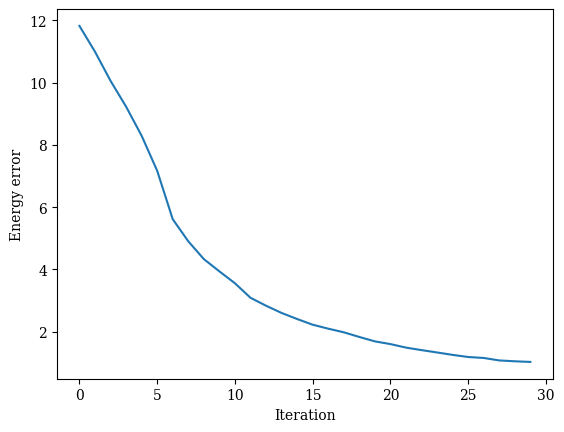

In [106]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [107]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [108]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [109]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

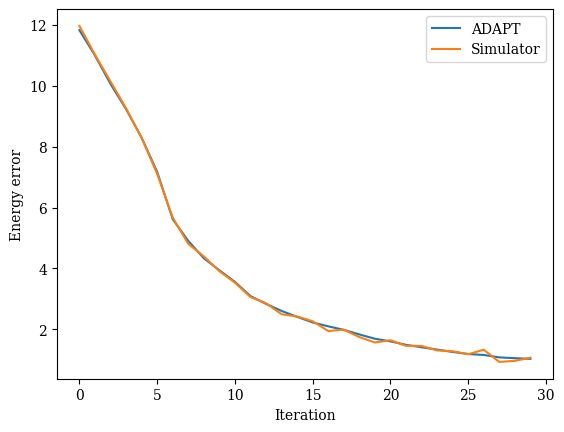

In [110]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [111]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [112]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sampler.run([to_run], shots=30_000)
    job = sim.run(to_run)
    # bit_array = job.result()[0].data.meas
    # bit_array = job.result().data().meas
    counts = job.result().data()['counts']
    bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'x': 7, 'cx': 4, 'rx': 2, 'barrier': 2, 'u2': 1, 'rz': 1, 'h': 1})
On circuit 1/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'cx': 8, 'x': 7, 'rx': 4, 'h': 3, 'barrier': 3, 'rz': 2, 'u2': 1})
On circuit 2/30
Gate counts (w/ pre-init passes): OrderedDict({'measure': 16, 'cx': 12, 'x': 7, 'rx': 6, 'h': 5, 'barrier': 4, 'rz': 3, 'u2': 1})
On circuit 3/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 16, 'measure': 16, 'rx': 8, 'x': 7, 'h': 7, 'barrier': 5, 'rz': 4, 'u2': 1})
On circuit 4/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 20, 'measure': 16, 'rx': 10, 'h': 9, 'x': 7, 'barrier': 6, 'rz': 5, 'u2': 1})
On circuit 5/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 26, 'measure': 16, 'rx': 12, 'h': 11, 'x': 7, 'barrier': 7, 'rz': 6, 'u2': 1})
On circuit 6/30
Gate counts (w/ pre-init passes): OrderedDict({'cx': 28, 'measure': 16, 'rx': 14, 'h': 13, 'barrier': 8, 'x

In [113]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

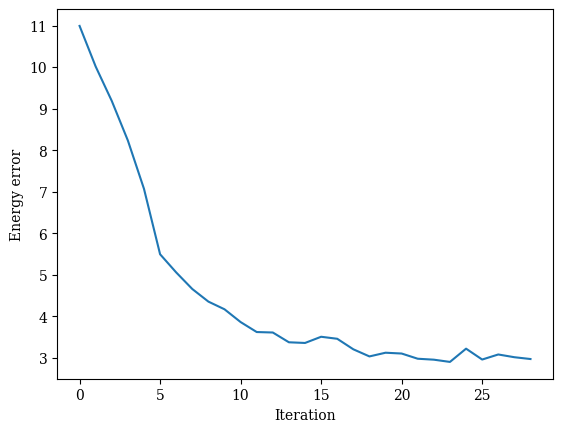

In [114]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [115]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    all_counts = collections.Counter()
    tuple_of_counts = tuple(counts_list[:i])
    assert len(tuple_of_counts) == i
    for counts in tuple_of_counts:
        for bitstring, count in counts.items():
            all_counts[bitstring] += count

    bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

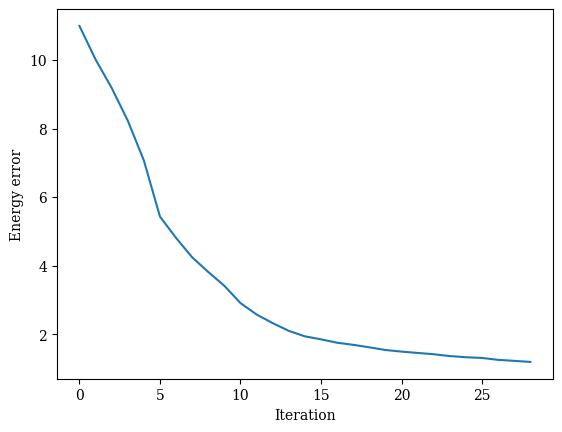

In [116]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

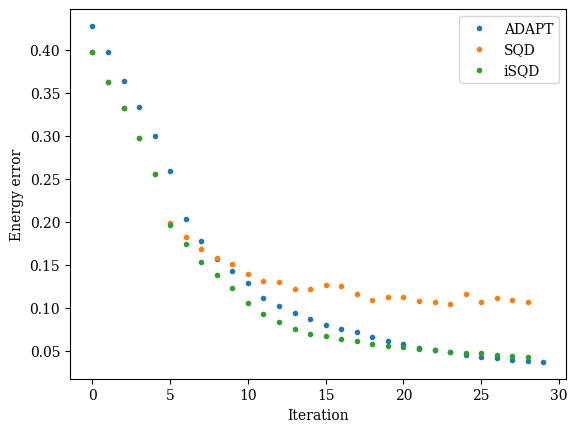

In [117]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()